# Power profile study
In this notebook, we compare the power profiles given by each software power meter, BMC and external power meter.

## Import necessary libraries

In [2]:
%load_ext autoreload
%autoreload 2

from visualize import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## Load experiment results

In [3]:
experiments_path = [
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-17_35_17',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-18_05_29',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-18_36_17',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-19_07_02',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-19_38_14',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-20_09_18',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-20_39_40',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-21_10_48',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-21_41_51',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-03-31-22_12_51'
]

experiments = []
for experiment_path in experiments_path:
    experiments.append(parse_experiment("../results/%s" % experiment_path))

# Additional processing is required for Scaphandre dataframes
# Scaphandre by component result dataframes will be joined into a single dataframe
process_scaphandre_dataframes(experiments)

## Total power profiles
### Prepare data for plotting

In [4]:
# Get by benchmark dataframes for each software-based power meter
benchmarks_powerapi = convert_exp_into_benchmark_dataframes(experiments, 'PowerAPI' ,'powerapi', 30)
benchmarks_scaphandre = convert_exp_into_benchmark_dataframes(experiments, 'Scaphandre' ,'scaphandre', 30)

# Construct result dataframe
result_df_plots = pd.DataFrame(columns=['timestamp', 'benchmark', 'plot_name', 'value'])

# Start and end lines
result_df_start_end_line = pd.DataFrame(columns=['benchmark', 'start', 'stop'])

for benchmark_index in range(len(benchmarks_powerapi)):
    benchmark_name = list(benchmarks_powerapi)[benchmark_index]
    # Getting info about benchmark from different solutions
    benchmark_powerapi = benchmarks_powerapi[benchmark_name]
    benchmark_scaphandre = benchmarks_scaphandre[benchmark_name]

    # Kwollect
    ## Get a list of kwollect dataframes
    experiments_kwollect_dataframes = [*get_dataframes_only_from_benchmark(benchmark_powerapi['kwollect']), *get_dataframes_only_from_benchmark(benchmark_scaphandre['kwollect'])]
    
    ## Calculate dataframe of median value
    ## Before calculating the median values, we need to round the timestamps
    ## Rounding is required to be able to join multiple dataframes for median value calculations
    ## We are going BMC floor at 5 seconds and Wattmeter at 1 second
    ## This matches their sample rates
    floor_values = [
        {
            'column_name': 'metric_id',
            'column_value': 'bmc_node_power_watt',
            'timestamp_floor': '5s'
        },
        {
            'column_name': 'metric_id',
            'column_value': 'wattmetre_power_watt',
            'timestamp_floor': '1s'
        }
    ]
    
    ## Calculate median values and create plottable dataframe
    kwollect_median_values_df = calculate_median_values(experiments_kwollect_dataframes, ['timestamp', 'metric_id'], 'value', floor_values)
    result_df_plot_kwollect_median = create_plottable_df_for_kwollect(kwollect_median_values_df, benchmark_name, plotname_postfix='')
    ## Calculate min values and create plottable dataframe
    kwollect_min_values_df = calculate_min_values(experiments_kwollect_dataframes, ['timestamp', 'metric_id'], 'value', floor_values)
    result_df_plot_kwollect_min = create_plottable_df_for_kwollect(kwollect_min_values_df, benchmark_name, plotname_postfix='')
    ## Calculate max values and create plottable dataframe
    kwollect_max_values_df = calculate_max_values(experiments_kwollect_dataframes, ['timestamp', 'metric_id'], 'value', floor_values)
    result_df_plot_kwollect_max = create_plottable_df_for_kwollect(kwollect_max_values_df, benchmark_name, plotname_postfix='')
    ## Join median, min and max values
    result_df_plot_kwollect = pd.concat([result_df_plot_kwollect_min, result_df_plot_kwollect_median, result_df_plot_kwollect_max], ignore_index=True)
    #result_df_plot_kwollect = result_df_plot_kwollect_median

    ## Substract a part of offset
    ## Offset subtraction is needed to simulate y-axis cutting
    ## The subtracted values will then be added back into the y-axis values
    result_df_plot_kwollect['value'] = result_df_plot_kwollect['value'] - 650

    # Scaphandre
    ## Get a list of scaphandre dataframes
    experiments_scaphandre_dataframes = get_dataframes_only_from_benchmark(benchmark_scaphandre['scaphandre'])
    ## Calculate a median values and create plottable dataframe
    scaphandre_median_values_df = calculate_median_values(experiments_scaphandre_dataframes, ['timestamp', 'target'], 'value', timestamp_floor='5s')
    result_df_plot_scaphandre_median = create_plottable_df_for_scaphandre(scaphandre_median_values_df, benchmark_name, targets = ['total'], plotname_postfix='')
    ## Calculate a min values and create plottable dataframe
    scaphandre_min_values_df = calculate_min_values(experiments_scaphandre_dataframes, ['timestamp', 'target'], 'value', timestamp_floor='5s')
    result_df_plot_scaphandre_min = create_plottable_df_for_scaphandre(scaphandre_min_values_df, benchmark_name, targets = ['total'], plotname_postfix='')
    ## Calculate a max values and create plottable dataframe
    scaphandre_max_values_df = calculate_max_values(experiments_scaphandre_dataframes, ['timestamp', 'target'], 'value', timestamp_floor='5s')
    result_df_plot_scaphandre_max = create_plottable_df_for_scaphandre(scaphandre_max_values_df, benchmark_name, targets = ['total'], plotname_postfix='')
    ## Join median, min and max values
    result_df_plot_scaphandre = pd.concat([result_df_plot_scaphandre_min, result_df_plot_scaphandre_median, result_df_plot_scaphandre_max], ignore_index=True)
    #result_df_plot_scaphandre = result_df_plot_scaphandre_median

    # PowerAPI
    ## Get a list of powerapi dataframes
    experiments_powerapi_dataframes = get_dataframes_only_from_benchmark(benchmark_powerapi['powerapi'])
    ## Calculate a median value dataframe
    powerapi_median_values_df = calculate_median_values(experiments_powerapi_dataframes, ['timestamp', 'target', 'scope', 'socket'], 'power')
    result_df_plot_powerapi_median = create_plottable_df_for_powerapi(powerapi_median_values_df, benchmark_name, targets=['rapl'], scopes=['total'], plotname_postfix='')
    ## Calculate a min value dataframe
    powerapi_min_values_df = calculate_min_values(experiments_powerapi_dataframes, ['timestamp', 'target', 'scope', 'socket'], 'power')
    result_df_plot_powerapi_min = create_plottable_df_for_powerapi(powerapi_min_values_df, benchmark_name, targets=['rapl'], scopes=['total'], plotname_postfix='')
    ## Calculate a max value dataframe
    powerapi_max_values_df = calculate_max_values(experiments_powerapi_dataframes, ['timestamp', 'target', 'scope', 'socket'], 'power')
    result_df_plot_powerapi_max = create_plottable_df_for_powerapi(powerapi_max_values_df, benchmark_name, targets=['rapl'], scopes=['total'], plotname_postfix='')
    ## Join median, min and max values
    result_df_plot_powerapi = pd.concat([result_df_plot_powerapi_min, result_df_plot_powerapi_median, result_df_plot_powerapi_max], ignore_index=True)
    #result_df_plot_powerapi = result_df_plot_powerapi_median

    # Add plottable dataframe to result dataframe
    result_df_plots = pd.concat([result_df_plots, result_df_plot_scaphandre, result_df_plot_kwollect, result_df_plot_powerapi], ignore_index=True)

result_df_plots

,timestamp,benchmark,plot_name,value
0,0 days 00:00:00,EP NAS Benchmark,scaphandre_total,165.525012
1,0 days 00:00:05,EP NAS Benchmark,scaphandre_total,165.587763
2,0 days 00:00:10,EP NAS Benchmark,scaphandre_total,165.541041
3,0 days 00:00:15,EP NAS Benchmark,scaphandre_total,165.456229
4,0 days 00:00:20,EP NAS Benchmark,scaphandre_total,165.455732
...,...,...,...,...
2839,0 days 00:03:08,MG NAS Benchmark,powerapi_rapl_total,166.841888
2840,0 days 00:03:09,MG NAS Benchmark,powerapi_rapl_total,166.269394
2841,0 days 00:03:10,MG NAS Benchmark,powerapi_rapl_total,166.601700
2842,0 days 00:03:11,MG NAS Benchmark,powerapi_rapl_total,166.399094


### Plot total power profiles

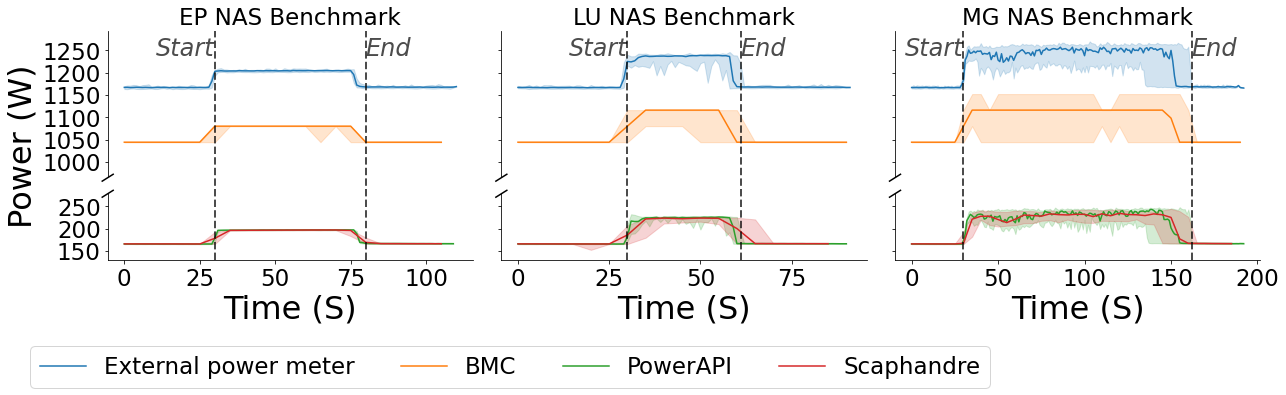

In [5]:
# Converting timestamp into seconds
result_df_plots['timestamp_sec'] = result_df_plots['timestamp'].dt.total_seconds()

plt.rcParams.update({'font.size': 23})
grid = sns.relplot(
    data=result_df_plots,
    x="timestamp_sec", y="value",
    hue="plot_name", 
    col="benchmark",
    kind="line",
    aspect=1.2,
    height=5,
    hue_order=['kwollect_wattmeter', 'kwollect_bmc', 'powerapi_rapl_total', 'scaphandre_total'],
    facet_kws={'sharex': False, 'sharey': True},
    estimator=np.median
)
grid.set_titles(template='{col_name}')
grid.set_xlabels('Time (S)', fontsize="32")
grid.set_ylabels('Power (W)', fontsize="32")

# Change legend texts
grid.legend.set_title(None)
for t, l in zip(grid.legend.texts, ['External power meter', 'BMC', 'PowerAPI', 'Scaphandre']):
    t.set_text(l)

# Change y ticks and add a horizontal lines that cut the y-axis at 300
## This gives the impression that the graph is abbreviated in the middle
plt.yticks([150,200,250,300,350,400,450,500,550,600,650],[150,200,250,'',1000,1050,1100,1150,1200,1250,1300])
axes = grid.axes.flatten()
d = .015
for ax in axes:
    # Draw the y axis cut lines
    ax.plot((-d, +d), (0.36 - d, 0.36 + d), transform=ax.transAxes, color='k', clip_on=False, zorder=4)       
    ax.plot((-d, +d), (0.29 - d, 0.29 + d), transform=ax.transAxes, color='k', clip_on=False, zorder=4)  

    # Hide the cutted part of y axis
    ax.plot((0, 0), (0.294, 0.357), transform=ax.transAxes, color='w', clip_on=False, linewidth=2, zorder=3)  
    ax.plot((-d, 0), (0.33, 0.33), transform=ax.transAxes, color='w', clip_on=False, linewidth=3, zorder=3)  

# Position legend
sns.move_legend(grid,
    "upper left",
    bbox_to_anchor=(0.024, 0.02),
    ncol=5,
    frameon=True
)

# Calulate start and end time of benchmarks
min_timestamp_df = result_df_plots[result_df_plots['plot_name'] == 'kwollect_wattmeter'].groupby(['timestamp','benchmark','plot_name'], as_index=False)['value'].min()
min_timestamp_df = min_timestamp_df.groupby(['benchmark','plot_name'], as_index=False)['timestamp'].min()
min_timestamp_df['start'] = min_timestamp_df['timestamp'].dt.total_seconds() + 30

max_timestamp_df = result_df_plots[result_df_plots['plot_name'] == 'kwollect_wattmeter'].groupby(['timestamp','benchmark','plot_name'], as_index=False)['value'].max()
max_timestamp_df = max_timestamp_df.groupby(['benchmark','plot_name'], as_index=False)['timestamp'].max()
max_timestamp_df['end'] = max_timestamp_df['timestamp'].dt.total_seconds() - 30

# Add start and end time lines 
for n, ax in enumerate(grid.axes.flat):
    ax.axvline(min_timestamp_df['start'].values[n], 0, 1250, linewidth=2, color='black', alpha=0.7, linestyle='--')
    ax.axvline(max_timestamp_df['end'].values[n], 0, 1250, linewidth=2, color='black', alpha=0.7, linestyle='--')
    ax.text(min_timestamp_df['start'].values[n], 630, "Start", fontsize=24, ha='right', va='top', alpha=0.7, fontstyle= 'italic')
    ax.text(max_timestamp_df['end'].values[n], 630, "End", fontsize=24, ha='left', va='top', alpha=0.7, fontstyle= 'italic')

# Save figures in pdf and png formats
grid.savefig('../figures/graph_3_solutions_time_series_no_energy_scope.pdf')
grid.savefig('../figures/graph_3_solutions_time_series_no_energy_scope.png')

## Per component power profile
### Prepare data for plotting

In [6]:
benchmarks_powerapi = convert_exp_into_benchmark_dataframes(experiments, 'PowerAPI' ,'powerapi', 30)
benchmarks_scaphandre = convert_exp_into_benchmark_dataframes(experiments, 'Scaphandre' ,'scaphandre', 30)

# Construct result dataframe
result_df_plots_resource = pd.DataFrame(columns=['timestamp', 'benchmark', 'plot_name', 'value'])

for benchmark_index in range(len(benchmarks_powerapi)):
    benchmark_name = list(benchmarks_powerapi)[benchmark_index]
    # Getting info about benchmark from different solutions
    benchmark_powerapi = benchmarks_powerapi[benchmark_name]
    benchmark_scaphandre = benchmarks_scaphandre[benchmark_name]
 
    # Scaphandre
    ## Get a list of scaphandre dataframes
    experiments_scaphandre_dataframes = get_dataframes_only_from_benchmark(benchmark_scaphandre['scaphandre'])
    ## Calculate a median values and create plottable dataframe
    scaphandre_median_values_df = calculate_median_values(experiments_scaphandre_dataframes, ['timestamp', 'target'], 'value', timestamp_floor='5s')
    result_df_plot_scaphandre_median = create_plottable_df_for_scaphandre(scaphandre_median_values_df, benchmark_name, targets = ['host', 'dram'], plotname_postfix='')
    ## Calculate a min values and create plottable dataframe
    scaphandre_min_values_df = calculate_min_values(experiments_scaphandre_dataframes, ['timestamp', 'target'], 'value', timestamp_floor='5s')
    result_df_plot_scaphandre_min = create_plottable_df_for_scaphandre(scaphandre_min_values_df, benchmark_name, targets = ['host', 'dram'], plotname_postfix='')
    ## Calculate a max values and create plottable dataframe
    scaphandre_max_values_df = calculate_max_values(experiments_scaphandre_dataframes, ['timestamp', 'target'], 'value', timestamp_floor='5s')
    result_df_plot_scaphandre_max = create_plottable_df_for_scaphandre(scaphandre_max_values_df, benchmark_name, targets = ['host', 'dram'], plotname_postfix='')
    ## Join median, min and max values
    result_df_plot_scaphandre = pd.concat([result_df_plot_scaphandre_min, result_df_plot_scaphandre_median, result_df_plot_scaphandre_max], ignore_index=True)
    #result_df_plot_scaphandre = result_df_plot_scaphandre_median

    # PowerAPI
    ## Get a list of powerapi dataframes
    experiments_powerapi_dataframes = get_dataframes_only_from_benchmark(benchmark_powerapi['powerapi'])
    ## Calculate a median value dataframe
    powerapi_median_values_df = calculate_median_values(experiments_powerapi_dataframes, ['timestamp', 'target', 'scope', 'socket'], 'power')
    result_df_plot_powerapi_median = create_plottable_df_for_powerapi(powerapi_median_values_df, benchmark_name, targets=['rapl'], scopes=['dram', 'cpu'], plotname_postfix='')
    ## Calculate a min value dataframe
    powerapi_min_values_df = calculate_min_values(experiments_powerapi_dataframes, ['timestamp', 'target', 'scope', 'socket'], 'power')
    result_df_plot_powerapi_min = create_plottable_df_for_powerapi(powerapi_min_values_df, benchmark_name, targets=['rapl'], scopes=['dram', 'cpu'], plotname_postfix='')
    ## Calculate a max value dataframe
    powerapi_max_values_df = calculate_max_values(experiments_powerapi_dataframes, ['timestamp', 'target', 'scope', 'socket'], 'power')
    result_df_plot_powerapi_max = create_plottable_df_for_powerapi(powerapi_max_values_df, benchmark_name, targets=['rapl'], scopes=['dram', 'cpu'], plotname_postfix='')
    ## Join median, min and max values
    result_df_plot_powerapi = pd.concat([result_df_plot_powerapi_min, result_df_plot_powerapi_median, result_df_plot_powerapi_max], ignore_index=True)
    #result_df_plot_powerapi = result_df_plot_powerapi_median

    # Add plottable dataframe to result dataframe
    result_df_plots_resource = pd.concat([result_df_plots_resource, result_df_plot_scaphandre, result_df_plot_powerapi], ignore_index=True)

result_df_plots_resource

,timestamp,benchmark,plot_name,value
0,0 days 00:00:00,EP NAS Benchmark,scaphandre_host,140.048973
1,0 days 00:00:05,EP NAS Benchmark,scaphandre_host,140.103693
2,0 days 00:00:10,EP NAS Benchmark,scaphandre_host,140.043378
3,0 days 00:00:15,EP NAS Benchmark,scaphandre_host,139.973920
4,0 days 00:00:20,EP NAS Benchmark,scaphandre_host,139.967869
...,...,...,...,...
2827,0 days 00:03:08,MG NAS Benchmark,powerapi_rapl_dram,25.494843
2828,0 days 00:03:09,MG NAS Benchmark,powerapi_rapl_dram,25.378830
2829,0 days 00:03:10,MG NAS Benchmark,powerapi_rapl_dram,25.508499
2830,0 days 00:03:11,MG NAS Benchmark,powerapi_rapl_dram,25.455124


### Plot per component power profiles

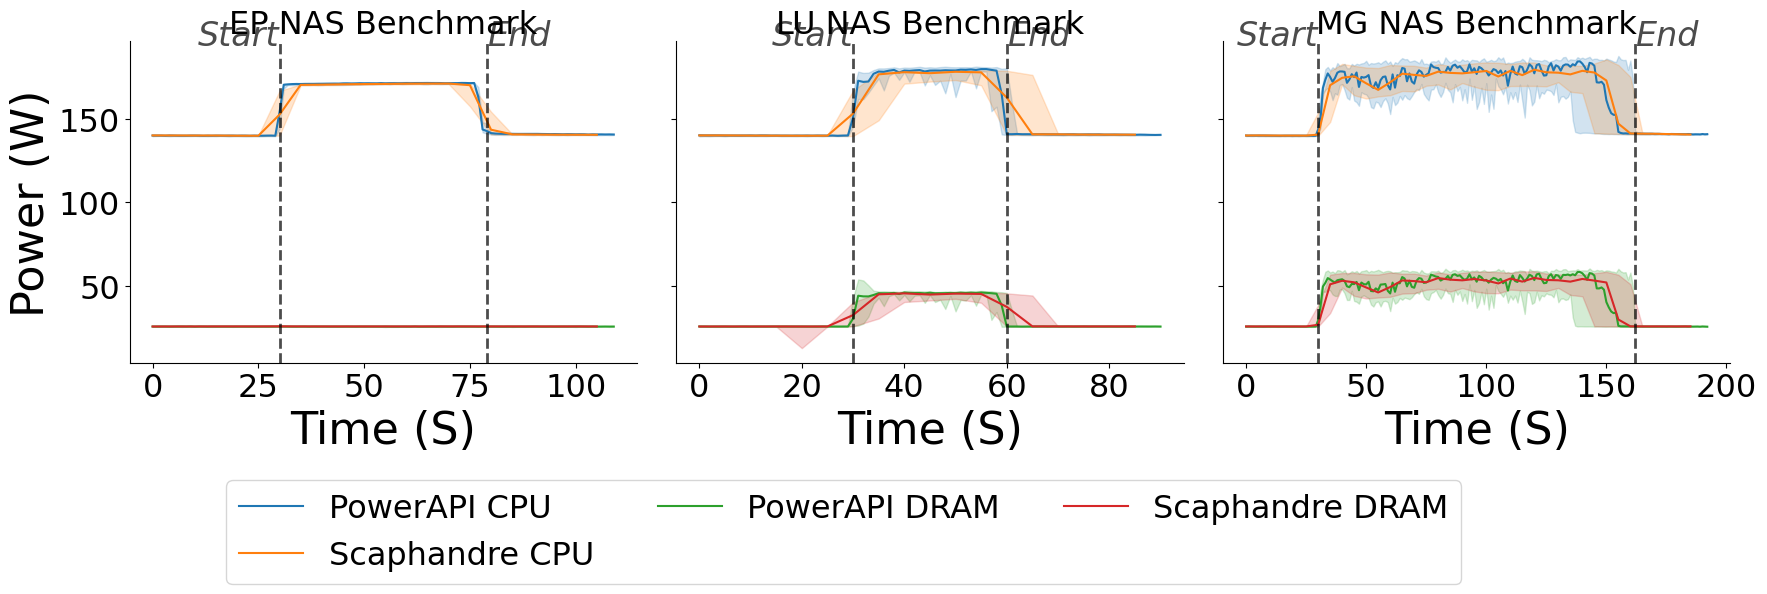

In [7]:
# Converting timestamp into seconds
result_df_plots_resource['timestamp_sec'] = result_df_plots_resource['timestamp'].dt.total_seconds()

plt.rcParams.update({'font.size': 23})

grid = sns.relplot(
    data=result_df_plots_resource,
    x="timestamp_sec", y="value",
    hue="plot_name", col="benchmark",
    kind="line",
    aspect=1.2,
    height=5,
    hue_order=['powerapi_rapl_cpu', 'scaphandre_host', 'powerapi_rapl_dram', 'scaphandre_dram'],
    facet_kws={'sharex': False, 'sharey': True},
    estimator=np.median
)

grid.set_titles(template='{col_name}')
grid.set_xlabels('Time (S)', fontsize='32')
grid.set_ylabels('Power (W)', fontsize='32')

# Change legend texts
grid.legend.set_title(None)
for t, l in zip(grid.legend.texts, ['PowerAPI CPU', 'Scaphandre CPU', 'PowerAPI DRAM', 'Scaphandre DRAM']):
    t.set_text(l)

# Position legend
sns.move_legend(grid,
    "upper left",
    bbox_to_anchor=(0.115, 0.02),
    ncol=3,
    frameon=True
)

# Calulate start and end time of benchmarks
min_timestamp_df = result_df_plots_resource[result_df_plots_resource['plot_name'] == 'powerapi_rapl_cpu'].groupby(['timestamp','benchmark','plot_name'], as_index=False)['value'].min()
min_timestamp_df = min_timestamp_df.groupby(['benchmark','plot_name'], as_index=False)['timestamp'].min()
min_timestamp_df['start'] = min_timestamp_df['timestamp'].dt.total_seconds() + 30

max_timestamp_df = result_df_plots_resource[result_df_plots_resource['plot_name'] == 'powerapi_rapl_cpu'].groupby(['timestamp','benchmark','plot_name'], as_index=False)['value'].max()
max_timestamp_df = max_timestamp_df.groupby(['benchmark','plot_name'], as_index=False)['timestamp'].max()
max_timestamp_df['end'] = max_timestamp_df['timestamp'].dt.total_seconds() - 30

# Add start and end time lines 
for n, ax in enumerate(grid.axes.flat):
    ax.axvline(min_timestamp_df['start'].values[n], 0, 1250, linewidth=2, color='black', alpha=0.7, linestyle='--')
    ax.axvline(max_timestamp_df['end'].values[n], 0, 1250, linewidth=2, color='black', alpha=0.7, linestyle='--')
    ax.text(min_timestamp_df['start'].values[n], 210, "Start", fontsize=24, ha='right', va='top', alpha=0.7, fontstyle= 'italic')
    ax.text(max_timestamp_df['end'].values[n], 210, "End", fontsize=24, ha='left', va='top', alpha=0.7, fontstyle= 'italic')

# Save figures in pdf and png formats
grid.savefig('../figures/powerprofile_by_server_resource_no_energy_scope.pdf')
grid.savefig('../figures/powerprofile_by_server_resource_no_energy_scope.png')